

# GAN implementation

## Data generation and preprocessing

In [0]:
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

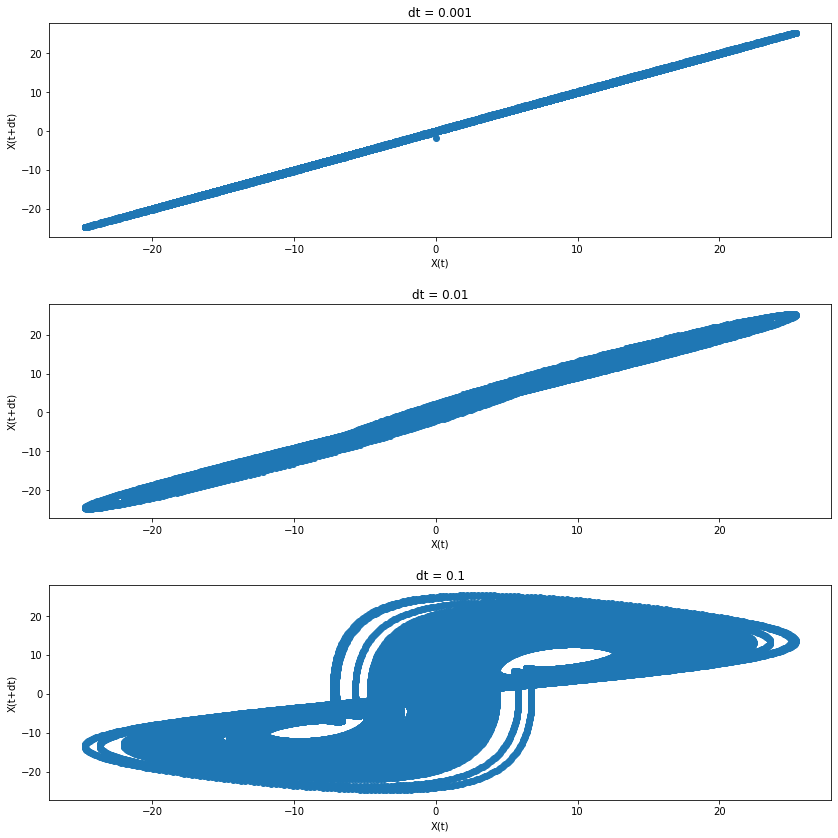

In [9]:
dt_vec = [0.001, 0.01, 0.1]

i = 1

x_ = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))

fig = plt.figure(figsize=(12,12))

for dt in dt_vec:
    
    xtplus = deque(x[:,1])
    xtplus.rotate(int(dt/dt_vec[0]))

    xtplus = np.array(list(xtplus))
    np.shape(xtplus)
    
    subplot(3,1,i)
    plt.scatter(x[:,1],xtplus)
    plt.title('dt = '+str(dt))
    plt.xlabel('X(t)')
    plt.ylabel('X(t+dt)')
    i += 1
    
fig.tight_layout(pad = 2)

In [0]:
def generate_data(N,l=100,T=1):
    
    #Model parameters
    #dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    
    #T = dt*(l+1)
    dt = T/(l+1)
    
    X = np.zeros((N,3*l))
    
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, arange(dt,T,dt), args=(sigma, rho, beta))
        X[n,...] = np.ndarray.flatten(x)
    return X

In [20]:
N = 1000
X = generate_data(N)

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
X.shape

(1000, 300)

## Create model

In [0]:
import keras
from keras.layers import Dense, Dropout, Input, Conv2D,LSTM, BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import Adam

In [0]:
class gan(object): 

    def __init__(self):

        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()
    
    def create_generator(self):
        
        self.generator.add(Dense(units=256,input_dim=300,activation ='selu'))
        #self.generator.add(LeakyReLU(alpha=0.2))

        self.generator.add(Dense(units=512,activation ='selu'))
        #self.generator.add(LeakyReLU(alpha=0.2))

        self.generator.add(Dense(units=1024,activation ='selu'))
        #self.generator.add(LeakyReLU(alpha=0.2))

        self.generator.add(Dense(units=300, activation='linear'))

        #self.generator.compile(loss='binary_crossentropy', optimizer='adam')
        
    def create_discriminator(self):
        
        self.discriminator.add(BatchNormalization(input_shape=[300]))

        self.discriminator.add(Dense(units=1024, activation='selu'))

        self.discriminator.add(Dense(units=512,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=256,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=1, activation='sigmoid'))

        self.discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    def create_gan(self):
        
        self.discriminator.trainable=False
        gan_input = Input(shape=(300,))
        x = self.generator(gan_input)
        gan_output= self.discriminator(x)
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list_generator = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss_generator = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])

            for _ in tqdm(range(batch_count)):

                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size

                #generate  random noise as an input  to  initialize the  generator
                noise= np.random.normal(0,1, [N, 300])

                generated_trajectory = self.generator.predict(noise)#.reshape(N,100,3)

                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 1 #0.9bat

                #Pre train discriminator on  fake and real data  before starting the gan. 
                self.discriminator.trainable=True
                
                loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)


                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, 300])
                y_gen = np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss_generator = loss_generator + self.gan.train_on_batch(noise, y_gen)
            loss_list_generator.append(loss_generator)
            loss_list_discriminator.append(loss_discriminator)
        return loss_list_generator, loss_list_discriminator
            #if e == 1 or e % 20 == 0:

                 #plot_generated_images(e, generator)
            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, 300])

        return np.transpose(self.generator.predict(noise))
        

In [153]:
g=gan()
g.generator_summary()
g.discriminator_summary()
g.gan_summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 256)               77056     
_________________________________________________________________
dense_137 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_138 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_139 (Dense)            (None, 300)               307500    
Total params: 1,041,452
Trainable params: 1,041,452
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 300)               1200      
____________________

## Train model

In [154]:
loss_generator,loss_discriminator = g.train(X_train,500,128)


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1



100%|██████████| 6/6 [00:00<00:00, 55.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2
Epoch 3



100%|██████████| 6/6 [00:00<00:00, 55.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4
Epoch 5



100%|██████████| 6/6 [00:00<00:00, 54.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6
Epoch 7



100%|██████████| 6/6 [00:00<00:00, 53.03it/s]

100%|██████████| 6/6 [00:00<00:00, 55.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8
Epoch 9



100%|██████████| 6/6 [00:00<00:00, 54.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10
Epoch 11



100%|██████████| 6/6 [00:00<00:00, 55.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12
Epoch 13



100%|██████████| 6/6 [00:00<00:00, 54.70it/s]

100%|██████████| 6/6 [00:00<00:00, 55.39it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14
Epoch 15



100%|██████████| 6/6 [00:00<00:00, 55.02it/s]

100%|██████████| 6/6 [00:00<00:00, 56.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16
Epoch 17



100%|██████████| 6/6 [00:00<00:00, 55.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18
Epoch 19



100%|██████████| 6/6 [00:00<00:00, 53.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20
Epoch 21



100%|██████████| 6/6 [00:00<00:00, 53.39it/s]

100%|██████████| 6/6 [00:00<00:00, 54.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22
Epoch 23



100%|██████████| 6/6 [00:00<00:00, 53.44it/s]

100%|██████████| 6/6 [00:00<00:00, 53.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24
Epoch 25



100%|██████████| 6/6 [00:00<00:00, 53.02it/s]

100%|██████████| 6/6 [00:00<00:00, 56.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26
Epoch 27



100%|██████████| 6/6 [00:00<00:00, 55.45it/s]

100%|██████████| 6/6 [00:00<00:00, 54.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28
Epoch 29



100%|██████████| 6/6 [00:00<00:00, 51.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30
Epoch 31



100%|██████████| 6/6 [00:00<00:00, 54.61it/s]

100%|██████████| 6/6 [00:00<00:00, 55.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32
Epoch 33



100%|██████████| 6/6 [00:00<00:00, 56.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34
Epoch 35



100%|██████████| 6/6 [00:00<00:00, 55.97it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36
Epoch 37



100%|██████████| 6/6 [00:00<00:00, 54.32it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38
Epoch 39



100%|██████████| 6/6 [00:00<00:00, 56.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40
Epoch 41



100%|██████████| 6/6 [00:00<00:00, 56.46it/s]

100%|██████████| 6/6 [00:00<00:00, 55.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42
Epoch 43



100%|██████████| 6/6 [00:00<00:00, 55.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44
Epoch 45



100%|██████████| 6/6 [00:00<00:00, 52.32it/s]

100%|██████████| 6/6 [00:00<00:00, 55.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46
Epoch 47



100%|██████████| 6/6 [00:00<00:00, 54.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48
Epoch 49



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50
Epoch 51



100%|██████████| 6/6 [00:00<00:00, 54.73it/s]

100%|██████████| 6/6 [00:00<00:00, 55.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 52
Epoch 53



100%|██████████| 6/6 [00:00<00:00, 53.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 54
Epoch 55



100%|██████████| 6/6 [00:00<00:00, 55.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 56
Epoch 57



100%|██████████| 6/6 [00:00<00:00, 53.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 58
Epoch 59



100%|██████████| 6/6 [00:00<00:00, 53.56it/s]

100%|██████████| 6/6 [00:00<00:00, 56.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 60
Epoch 61



100%|██████████| 6/6 [00:00<00:00, 53.32it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 62
Epoch 63



100%|██████████| 6/6 [00:00<00:00, 55.32it/s]

100%|██████████| 6/6 [00:00<00:00, 56.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 64
Epoch 65



100%|██████████| 6/6 [00:00<00:00, 56.86it/s]

100%|██████████| 6/6 [00:00<00:00, 56.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 66
Epoch 67



100%|██████████| 6/6 [00:00<00:00, 56.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 68
Epoch 69



100%|██████████| 6/6 [00:00<00:00, 54.89it/s]

100%|██████████| 6/6 [00:00<00:00, 54.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 70
Epoch 71



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 72
Epoch 73



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 74
Epoch 75



100%|██████████| 6/6 [00:00<00:00, 55.80it/s]

100%|██████████| 6/6 [00:00<00:00, 55.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 76
Epoch 77



100%|██████████| 6/6 [00:00<00:00, 55.54it/s]

100%|██████████| 6/6 [00:00<00:00, 54.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 78
Epoch 79



100%|██████████| 6/6 [00:00<00:00, 55.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 80
Epoch 81



100%|██████████| 6/6 [00:00<00:00, 54.09it/s]

100%|██████████| 6/6 [00:00<00:00, 53.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 82
Epoch 83



100%|██████████| 6/6 [00:00<00:00, 57.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 84
Epoch 85



100%|██████████| 6/6 [00:00<00:00, 56.03it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 86
Epoch 87



100%|██████████| 6/6 [00:00<00:00, 55.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 88
Epoch 89



100%|██████████| 6/6 [00:00<00:00, 54.81it/s]

100%|██████████| 6/6 [00:00<00:00, 57.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 90
Epoch 91



100%|██████████| 6/6 [00:00<00:00, 56.27it/s]

100%|██████████| 6/6 [00:00<00:00, 57.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 92
Epoch 93



100%|██████████| 6/6 [00:00<00:00, 54.05it/s]

100%|██████████| 6/6 [00:00<00:00, 53.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 94
Epoch 95



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 96
Epoch 97



100%|██████████| 6/6 [00:00<00:00, 56.63it/s]

100%|██████████| 6/6 [00:00<00:00, 53.38it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 98
Epoch 99



100%|██████████| 6/6 [00:00<00:00, 52.46it/s]

100%|██████████| 6/6 [00:00<00:00, 54.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 100
Epoch 101



100%|██████████| 6/6 [00:00<00:00, 53.70it/s]

100%|██████████| 6/6 [00:00<00:00, 54.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 102
Epoch 103



100%|██████████| 6/6 [00:00<00:00, 53.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 104
Epoch 105



100%|██████████| 6/6 [00:00<00:00, 52.93it/s]

100%|██████████| 6/6 [00:00<00:00, 54.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 106
Epoch 107



100%|██████████| 6/6 [00:00<00:00, 53.45it/s]

100%|██████████| 6/6 [00:00<00:00, 54.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 108
Epoch 109



100%|██████████| 6/6 [00:00<00:00, 54.70it/s]

100%|██████████| 6/6 [00:00<00:00, 55.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 110
Epoch 111



100%|██████████| 6/6 [00:00<00:00, 55.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 112
Epoch 113



100%|██████████| 6/6 [00:00<00:00, 54.37it/s]

100%|██████████| 6/6 [00:00<00:00, 57.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 114
Epoch 115



100%|██████████| 6/6 [00:00<00:00, 54.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 116
Epoch 117



100%|██████████| 6/6 [00:00<00:00, 54.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 118
Epoch 119



100%|██████████| 6/6 [00:00<00:00, 54.42it/s]

100%|██████████| 6/6 [00:00<00:00, 53.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 120
Epoch 121



100%|██████████| 6/6 [00:00<00:00, 54.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 122
Epoch 123



100%|██████████| 6/6 [00:00<00:00, 52.99it/s]

100%|██████████| 6/6 [00:00<00:00, 56.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 124
Epoch 125



100%|██████████| 6/6 [00:00<00:00, 52.71it/s]

100%|██████████| 6/6 [00:00<00:00, 57.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 126
Epoch 127



100%|██████████| 6/6 [00:00<00:00, 54.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 128
Epoch 129



100%|██████████| 6/6 [00:00<00:00, 56.14it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 130
Epoch 131



100%|██████████| 6/6 [00:00<00:00, 54.04it/s]

100%|██████████| 6/6 [00:00<00:00, 52.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 132
Epoch 133



100%|██████████| 6/6 [00:00<00:00, 53.26it/s]

100%|██████████| 6/6 [00:00<00:00, 54.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 134
Epoch 135



100%|██████████| 6/6 [00:00<00:00, 53.83it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 136
Epoch 137



100%|██████████| 6/6 [00:00<00:00, 55.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 138
Epoch 139



100%|██████████| 6/6 [00:00<00:00, 53.84it/s]

100%|██████████| 6/6 [00:00<00:00, 55.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 140
Epoch 141



100%|██████████| 6/6 [00:00<00:00, 56.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 142
Epoch 143



100%|██████████| 6/6 [00:00<00:00, 55.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 144
Epoch 145



100%|██████████| 6/6 [00:00<00:00, 54.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 146
Epoch 147



100%|██████████| 6/6 [00:00<00:00, 54.14it/s]

100%|██████████| 6/6 [00:00<00:00, 54.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 148
Epoch 149



100%|██████████| 6/6 [00:00<00:00, 54.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 150
Epoch 151



100%|██████████| 6/6 [00:00<00:00, 53.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 152
Epoch 153



100%|██████████| 6/6 [00:00<00:00, 53.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 154
Epoch 155



100%|██████████| 6/6 [00:00<00:00, 56.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 156
Epoch 157



100%|██████████| 6/6 [00:00<00:00, 52.10it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 158
Epoch 159



100%|██████████| 6/6 [00:00<00:00, 55.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 160
Epoch 161



100%|██████████| 6/6 [00:00<00:00, 56.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 162
Epoch 163



100%|██████████| 6/6 [00:00<00:00, 53.40it/s]

100%|██████████| 6/6 [00:00<00:00, 54.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 164
Epoch 165



100%|██████████| 6/6 [00:00<00:00, 52.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 166
Epoch 167



100%|██████████| 6/6 [00:00<00:00, 54.77it/s]

100%|██████████| 6/6 [00:00<00:00, 56.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 168
Epoch 169



100%|██████████| 6/6 [00:00<00:00, 53.62it/s]

100%|██████████| 6/6 [00:00<00:00, 52.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 170
Epoch 171



100%|██████████| 6/6 [00:00<00:00, 59.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 172
Epoch 173



100%|██████████| 6/6 [00:00<00:00, 53.79it/s]

100%|██████████| 6/6 [00:00<00:00, 52.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 174
Epoch 175



100%|██████████| 6/6 [00:00<00:00, 53.73it/s]

100%|██████████| 6/6 [00:00<00:00, 54.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 176
Epoch 177



100%|██████████| 6/6 [00:00<00:00, 52.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 178
Epoch 179



100%|██████████| 6/6 [00:00<00:00, 54.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 180
Epoch 181



100%|██████████| 6/6 [00:00<00:00, 55.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 182
Epoch 183



100%|██████████| 6/6 [00:00<00:00, 54.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 184
Epoch 185



100%|██████████| 6/6 [00:00<00:00, 56.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 186
Epoch 187



100%|██████████| 6/6 [00:00<00:00, 55.38it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 188
Epoch 189



100%|██████████| 6/6 [00:00<00:00, 53.27it/s]

100%|██████████| 6/6 [00:00<00:00, 56.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 190
Epoch 191



100%|██████████| 6/6 [00:00<00:00, 56.72it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 192
Epoch 193



100%|██████████| 6/6 [00:00<00:00, 56.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 194
Epoch 195



100%|██████████| 6/6 [00:00<00:00, 54.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 196
Epoch 197



100%|██████████| 6/6 [00:00<00:00, 54.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 198
Epoch 199



100%|██████████| 6/6 [00:00<00:00, 53.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 200
Epoch 201



100%|██████████| 6/6 [00:00<00:00, 53.16it/s]

100%|██████████| 6/6 [00:00<00:00, 54.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 202
Epoch 203



100%|██████████| 6/6 [00:00<00:00, 53.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 204
Epoch 205



100%|██████████| 6/6 [00:00<00:00, 55.73it/s]

100%|██████████| 6/6 [00:00<00:00, 53.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 206
Epoch 207



100%|██████████| 6/6 [00:00<00:00, 55.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 208
Epoch 209



100%|██████████| 6/6 [00:00<00:00, 53.99it/s]

100%|██████████| 6/6 [00:00<00:00, 54.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 210
Epoch 211



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 212
Epoch 213



100%|██████████| 6/6 [00:00<00:00, 52.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 214
Epoch 215



100%|██████████| 6/6 [00:00<00:00, 55.43it/s]

100%|██████████| 6/6 [00:00<00:00, 54.24it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 216
Epoch 217



100%|██████████| 6/6 [00:00<00:00, 54.22it/s]

100%|██████████| 6/6 [00:00<00:00, 52.83it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 218
Epoch 219



100%|██████████| 6/6 [00:00<00:00, 54.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 220
Epoch 221



100%|██████████| 6/6 [00:00<00:00, 54.84it/s]

100%|██████████| 6/6 [00:00<00:00, 55.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 222
Epoch 223



100%|██████████| 6/6 [00:00<00:00, 54.18it/s]

100%|██████████| 6/6 [00:00<00:00, 53.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 224
Epoch 225



100%|██████████| 6/6 [00:00<00:00, 53.73it/s]

100%|██████████| 6/6 [00:00<00:00, 56.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 226
Epoch 227



100%|██████████| 6/6 [00:00<00:00, 56.85it/s]

100%|██████████| 6/6 [00:00<00:00, 52.65it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 228
Epoch 229



100%|██████████| 6/6 [00:00<00:00, 56.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 230
Epoch 231



100%|██████████| 6/6 [00:00<00:00, 54.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 232
Epoch 233



100%|██████████| 6/6 [00:00<00:00, 55.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 234
Epoch 235



100%|██████████| 6/6 [00:00<00:00, 54.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 236
Epoch 237



100%|██████████| 6/6 [00:00<00:00, 52.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 238
Epoch 239



100%|██████████| 6/6 [00:00<00:00, 55.47it/s]

100%|██████████| 6/6 [00:00<00:00, 55.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 240
Epoch 241



100%|██████████| 6/6 [00:00<00:00, 54.33it/s]

100%|██████████| 6/6 [00:00<00:00, 54.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 242
Epoch 243



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 244
Epoch 245



100%|██████████| 6/6 [00:00<00:00, 55.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 246
Epoch 247



100%|██████████| 6/6 [00:00<00:00, 56.20it/s]

100%|██████████| 6/6 [00:00<00:00, 53.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 248
Epoch 249



100%|██████████| 6/6 [00:00<00:00, 54.97it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 250
Epoch 251



100%|██████████| 6/6 [00:00<00:00, 53.75it/s]

100%|██████████| 6/6 [00:00<00:00, 55.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 252
Epoch 253



100%|██████████| 6/6 [00:00<00:00, 55.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 254
Epoch 255



100%|██████████| 6/6 [00:00<00:00, 53.36it/s]

100%|██████████| 6/6 [00:00<00:00, 55.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 256
Epoch 257



100%|██████████| 6/6 [00:00<00:00, 55.53it/s]

100%|██████████| 6/6 [00:00<00:00, 54.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 258
Epoch 259



100%|██████████| 6/6 [00:00<00:00, 54.89it/s]

100%|██████████| 6/6 [00:00<00:00, 57.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 260
Epoch 261



100%|██████████| 6/6 [00:00<00:00, 54.07it/s]

100%|██████████| 6/6 [00:00<00:00, 55.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 262
Epoch 263



100%|██████████| 6/6 [00:00<00:00, 52.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 264
Epoch 265



100%|██████████| 6/6 [00:00<00:00, 56.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 266
Epoch 267



100%|██████████| 6/6 [00:00<00:00, 54.39it/s]

100%|██████████| 6/6 [00:00<00:00, 55.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 268
Epoch 269



100%|██████████| 6/6 [00:00<00:00, 54.45it/s]

100%|██████████| 6/6 [00:00<00:00, 55.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 270
Epoch 271



100%|██████████| 6/6 [00:00<00:00, 55.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 272
Epoch 273



100%|██████████| 6/6 [00:00<00:00, 54.24it/s]

100%|██████████| 6/6 [00:00<00:00, 56.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 274
Epoch 275



100%|██████████| 6/6 [00:00<00:00, 55.77it/s]

100%|██████████| 6/6 [00:00<00:00, 56.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 276
Epoch 277



100%|██████████| 6/6 [00:00<00:00, 53.39it/s]

100%|██████████| 6/6 [00:00<00:00, 56.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 278
Epoch 279



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 280
Epoch 281



100%|██████████| 6/6 [00:00<00:00, 53.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 282
Epoch 283



100%|██████████| 6/6 [00:00<00:00, 53.16it/s]

100%|██████████| 6/6 [00:00<00:00, 53.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 284
Epoch 285



100%|██████████| 6/6 [00:00<00:00, 55.77it/s]

100%|██████████| 6/6 [00:00<00:00, 55.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 286
Epoch 287



100%|██████████| 6/6 [00:00<00:00, 53.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 288
Epoch 289



100%|██████████| 6/6 [00:00<00:00, 54.01it/s]

100%|██████████| 6/6 [00:00<00:00, 53.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 290
Epoch 291



100%|██████████| 6/6 [00:00<00:00, 55.94it/s]

100%|██████████| 6/6 [00:00<00:00, 56.17it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 292
Epoch 293



100%|██████████| 6/6 [00:00<00:00, 53.05it/s]

100%|██████████| 6/6 [00:00<00:00, 56.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 294
Epoch 295



100%|██████████| 6/6 [00:00<00:00, 55.68it/s]

100%|██████████| 6/6 [00:00<00:00, 55.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 296
Epoch 297



100%|██████████| 6/6 [00:00<00:00, 55.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 298
Epoch 299



100%|██████████| 6/6 [00:00<00:00, 53.30it/s]

100%|██████████| 6/6 [00:00<00:00, 54.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 300
Epoch 301



100%|██████████| 6/6 [00:00<00:00, 54.33it/s]

100%|██████████| 6/6 [00:00<00:00, 52.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 302
Epoch 303



100%|██████████| 6/6 [00:00<00:00, 53.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 304
Epoch 305



100%|██████████| 6/6 [00:00<00:00, 57.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 306
Epoch 307



100%|██████████| 6/6 [00:00<00:00, 54.06it/s]

100%|██████████| 6/6 [00:00<00:00, 56.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 308
Epoch 309



100%|██████████| 6/6 [00:00<00:00, 54.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 310
Epoch 311



100%|██████████| 6/6 [00:00<00:00, 55.36it/s]

100%|██████████| 6/6 [00:00<00:00, 52.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 312
Epoch 313



100%|██████████| 6/6 [00:00<00:00, 55.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 314
Epoch 315



100%|██████████| 6/6 [00:00<00:00, 55.03it/s]

100%|██████████| 6/6 [00:00<00:00, 57.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 316
Epoch 317



100%|██████████| 6/6 [00:00<00:00, 53.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 318
Epoch 319



100%|██████████| 6/6 [00:00<00:00, 54.76it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 320
Epoch 321



100%|██████████| 6/6 [00:00<00:00, 55.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 322
Epoch 323



100%|██████████| 6/6 [00:00<00:00, 54.12it/s]

100%|██████████| 6/6 [00:00<00:00, 56.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 324
Epoch 325



100%|██████████| 6/6 [00:00<00:00, 53.34it/s]

100%|██████████| 6/6 [00:00<00:00, 54.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 326
Epoch 327



100%|██████████| 6/6 [00:00<00:00, 56.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 328
Epoch 329



100%|██████████| 6/6 [00:00<00:00, 51.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 330
Epoch 331



100%|██████████| 6/6 [00:00<00:00, 53.20it/s]

100%|██████████| 6/6 [00:00<00:00, 57.83it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 332
Epoch 333



100%|██████████| 6/6 [00:00<00:00, 52.44it/s]

100%|██████████| 6/6 [00:00<00:00, 57.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 334
Epoch 335



100%|██████████| 6/6 [00:00<00:00, 54.97it/s]

100%|██████████| 6/6 [00:00<00:00, 54.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 336
Epoch 337



100%|██████████| 6/6 [00:00<00:00, 55.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 338
Epoch 339



100%|██████████| 6/6 [00:00<00:00, 54.47it/s]

100%|██████████| 6/6 [00:00<00:00, 55.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 340
Epoch 341



100%|██████████| 6/6 [00:00<00:00, 53.75it/s]

100%|██████████| 6/6 [00:00<00:00, 55.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 342
Epoch 343



100%|██████████| 6/6 [00:00<00:00, 55.93it/s]

100%|██████████| 6/6 [00:00<00:00, 56.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 344
Epoch 345



100%|██████████| 6/6 [00:00<00:00, 54.11it/s]

100%|██████████| 6/6 [00:00<00:00, 54.53it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 346
Epoch 347



100%|██████████| 6/6 [00:00<00:00, 54.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 348
Epoch 349



100%|██████████| 6/6 [00:00<00:00, 56.16it/s]

100%|██████████| 6/6 [00:00<00:00, 52.90it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 350
Epoch 351



100%|██████████| 6/6 [00:00<00:00, 55.62it/s]

100%|██████████| 6/6 [00:00<00:00, 56.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 352
Epoch 353



100%|██████████| 6/6 [00:00<00:00, 55.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 354
Epoch 355



100%|██████████| 6/6 [00:00<00:00, 55.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 356
Epoch 357



100%|██████████| 6/6 [00:00<00:00, 54.46it/s]

100%|██████████| 6/6 [00:00<00:00, 55.72it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 358
Epoch 359



100%|██████████| 6/6 [00:00<00:00, 54.26it/s]

100%|██████████| 6/6 [00:00<00:00, 56.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 360
Epoch 361



100%|██████████| 6/6 [00:00<00:00, 55.39it/s]

100%|██████████| 6/6 [00:00<00:00, 55.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 362
Epoch 363



100%|██████████| 6/6 [00:00<00:00, 54.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 364
Epoch 365



100%|██████████| 6/6 [00:00<00:00, 53.71it/s]

100%|██████████| 6/6 [00:00<00:00, 54.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 366
Epoch 367



100%|██████████| 6/6 [00:00<00:00, 54.03it/s]

100%|██████████| 6/6 [00:00<00:00, 56.14it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 368
Epoch 369



100%|██████████| 6/6 [00:00<00:00, 53.05it/s]

100%|██████████| 6/6 [00:00<00:00, 54.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 370
Epoch 371



100%|██████████| 6/6 [00:00<00:00, 54.78it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 372
Epoch 373



100%|██████████| 6/6 [00:00<00:00, 53.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 374
Epoch 375



100%|██████████| 6/6 [00:00<00:00, 54.18it/s]

100%|██████████| 6/6 [00:00<00:00, 55.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 376
Epoch 377



100%|██████████| 6/6 [00:00<00:00, 53.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 378
Epoch 379



100%|██████████| 6/6 [00:00<00:00, 54.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 380
Epoch 381



100%|██████████| 6/6 [00:00<00:00, 55.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 382
Epoch 383



100%|██████████| 6/6 [00:00<00:00, 54.42it/s]

100%|██████████| 6/6 [00:00<00:00, 53.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 384
Epoch 385



100%|██████████| 6/6 [00:00<00:00, 54.47it/s]

100%|██████████| 6/6 [00:00<00:00, 56.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 386
Epoch 387



100%|██████████| 6/6 [00:00<00:00, 54.12it/s]

100%|██████████| 6/6 [00:00<00:00, 58.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 388
Epoch 389



100%|██████████| 6/6 [00:00<00:00, 54.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 390
Epoch 391



100%|██████████| 6/6 [00:00<00:00, 55.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 392
Epoch 393



100%|██████████| 6/6 [00:00<00:00, 55.16it/s]

100%|██████████| 6/6 [00:00<00:00, 55.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 394
Epoch 395



100%|██████████| 6/6 [00:00<00:00, 54.23it/s]

100%|██████████| 6/6 [00:00<00:00, 54.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 396
Epoch 397



100%|██████████| 6/6 [00:00<00:00, 54.72it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 398
Epoch 399



100%|██████████| 6/6 [00:00<00:00, 52.70it/s]

100%|██████████| 6/6 [00:00<00:00, 53.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 400
Epoch 401



100%|██████████| 6/6 [00:00<00:00, 54.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 402
Epoch 403



100%|██████████| 6/6 [00:00<00:00, 54.66it/s]

100%|██████████| 6/6 [00:00<00:00, 56.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 404
Epoch 405



100%|██████████| 6/6 [00:00<00:00, 49.96it/s]

100%|██████████| 6/6 [00:00<00:00, 54.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 406
Epoch 407



100%|██████████| 6/6 [00:00<00:00, 55.02it/s]

100%|██████████| 6/6 [00:00<00:00, 55.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 408
Epoch 409



100%|██████████| 6/6 [00:00<00:00, 52.45it/s]

100%|██████████| 6/6 [00:00<00:00, 56.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 410
Epoch 411



100%|██████████| 6/6 [00:00<00:00, 54.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 412
Epoch 413



100%|██████████| 6/6 [00:00<00:00, 55.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 414
Epoch 415



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 416
Epoch 417



100%|██████████| 6/6 [00:00<00:00, 55.84it/s]

100%|██████████| 6/6 [00:00<00:00, 55.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 418
Epoch 419



100%|██████████| 6/6 [00:00<00:00, 55.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 420
Epoch 421



100%|██████████| 6/6 [00:00<00:00, 54.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 422
Epoch 423



100%|██████████| 6/6 [00:00<00:00, 53.40it/s]

100%|██████████| 6/6 [00:00<00:00, 56.17it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 424
Epoch 425



100%|██████████| 6/6 [00:00<00:00, 57.23it/s]

100%|██████████| 6/6 [00:00<00:00, 54.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 426
Epoch 427



100%|██████████| 6/6 [00:00<00:00, 53.21it/s]

100%|██████████| 6/6 [00:00<00:00, 54.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 428
Epoch 429



100%|██████████| 6/6 [00:00<00:00, 56.49it/s]

100%|██████████| 6/6 [00:00<00:00, 55.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 430
Epoch 431



100%|██████████| 6/6 [00:00<00:00, 56.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 432
Epoch 433



100%|██████████| 6/6 [00:00<00:00, 55.09it/s]

100%|██████████| 6/6 [00:00<00:00, 54.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 434
Epoch 435



100%|██████████| 6/6 [00:00<00:00, 54.90it/s]

100%|██████████| 6/6 [00:00<00:00, 56.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 436
Epoch 437



100%|██████████| 6/6 [00:00<00:00, 54.76it/s]

100%|██████████| 6/6 [00:00<00:00, 53.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 438
Epoch 439



100%|██████████| 6/6 [00:00<00:00, 57.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 440
Epoch 441



100%|██████████| 6/6 [00:00<00:00, 55.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 442
Epoch 443



100%|██████████| 6/6 [00:00<00:00, 53.65it/s]

100%|██████████| 6/6 [00:00<00:00, 57.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 444
Epoch 445



100%|██████████| 6/6 [00:00<00:00, 53.63it/s]

100%|██████████| 6/6 [00:00<00:00, 54.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 446
Epoch 447



100%|██████████| 6/6 [00:00<00:00, 53.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 448
Epoch 449



100%|██████████| 6/6 [00:00<00:00, 53.68it/s]

100%|██████████| 6/6 [00:00<00:00, 55.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 450
Epoch 451



100%|██████████| 6/6 [00:00<00:00, 53.53it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 452
Epoch 453



100%|██████████| 6/6 [00:00<00:00, 55.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 454
Epoch 455



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 456
Epoch 457



100%|██████████| 6/6 [00:00<00:00, 55.44it/s]

100%|██████████| 6/6 [00:00<00:00, 56.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 458
Epoch 459



100%|██████████| 6/6 [00:00<00:00, 53.60it/s]

100%|██████████| 6/6 [00:00<00:00, 56.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 460
Epoch 461



100%|██████████| 6/6 [00:00<00:00, 54.19it/s]

100%|██████████| 6/6 [00:00<00:00, 54.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 462
Epoch 463



100%|██████████| 6/6 [00:00<00:00, 53.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 464
Epoch 465



100%|██████████| 6/6 [00:00<00:00, 51.93it/s]

100%|██████████| 6/6 [00:00<00:00, 57.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 466
Epoch 467



100%|██████████| 6/6 [00:00<00:00, 54.65it/s]

100%|██████████| 6/6 [00:00<00:00, 53.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 468
Epoch 469



100%|██████████| 6/6 [00:00<00:00, 53.53it/s]

100%|██████████| 6/6 [00:00<00:00, 53.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 470
Epoch 471



100%|██████████| 6/6 [00:00<00:00, 54.87it/s]

100%|██████████| 6/6 [00:00<00:00, 54.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 472
Epoch 473



100%|██████████| 6/6 [00:00<00:00, 54.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 474
Epoch 475



100%|██████████| 6/6 [00:00<00:00, 53.79it/s]

100%|██████████| 6/6 [00:00<00:00, 53.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 476
Epoch 477



100%|██████████| 6/6 [00:00<00:00, 52.24it/s]

100%|██████████| 6/6 [00:00<00:00, 53.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 478
Epoch 479



100%|██████████| 6/6 [00:00<00:00, 54.43it/s]

100%|██████████| 6/6 [00:00<00:00, 54.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 480
Epoch 481



100%|██████████| 6/6 [00:00<00:00, 53.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 482
Epoch 483



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 484
Epoch 485



100%|██████████| 6/6 [00:00<00:00, 52.37it/s]

100%|██████████| 6/6 [00:00<00:00, 53.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 486
Epoch 487



100%|██████████| 6/6 [00:00<00:00, 54.96it/s]

100%|██████████| 6/6 [00:00<00:00, 55.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 488
Epoch 489



100%|██████████| 6/6 [00:00<00:00, 55.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 490
Epoch 491



100%|██████████| 6/6 [00:00<00:00, 56.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 492
Epoch 493



100%|██████████| 6/6 [00:00<00:00, 51.96it/s]

100%|██████████| 6/6 [00:00<00:00, 54.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 494
Epoch 495



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 496
Epoch 497



100%|██████████| 6/6 [00:00<00:00, 52.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 498
Epoch 499



100%|██████████| 6/6 [00:00<00:00, 52.99it/s]

100%|██████████| 6/6 [00:00<00:00, 49.92it/s]

Epoch 500


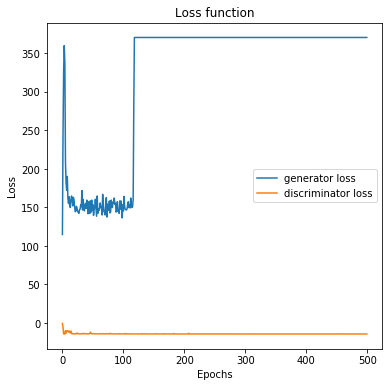

In [155]:
plt.figure(figsize=(6,6))
plt.plot(loss)
plt.plot(log(loss_discriminator))
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
plt.show()

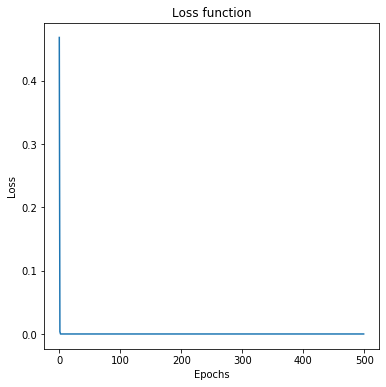

In [156]:
plt.figure(figsize=(6,6))
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

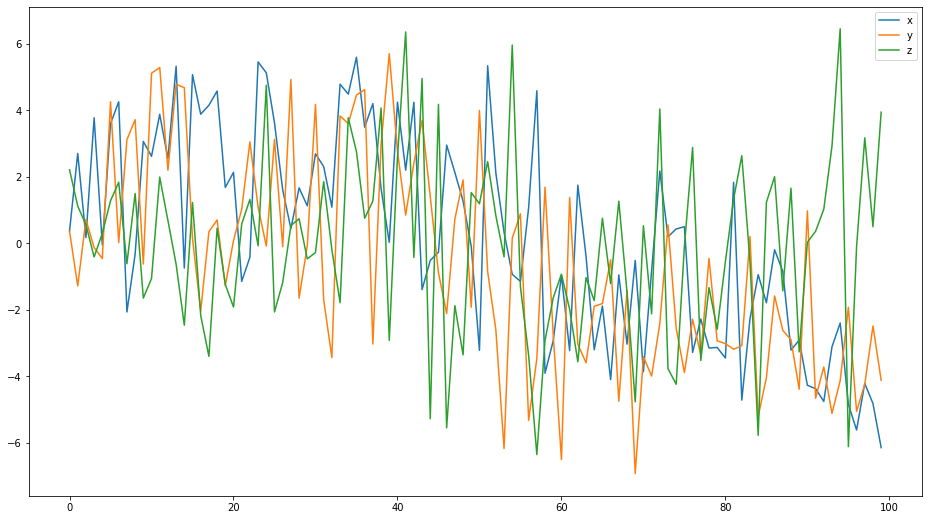

In [150]:
generated_data = g.generate(1)
generated_data = generated_data.reshape((int(np.shape(generated_data)[0]/3),3))
plt.plot(generated_data[:,0])
plt.plot(generated_data[:,1])
plt.plot(generated_data[:,2])
plt.legend(['x','y','z'])
plt.show()

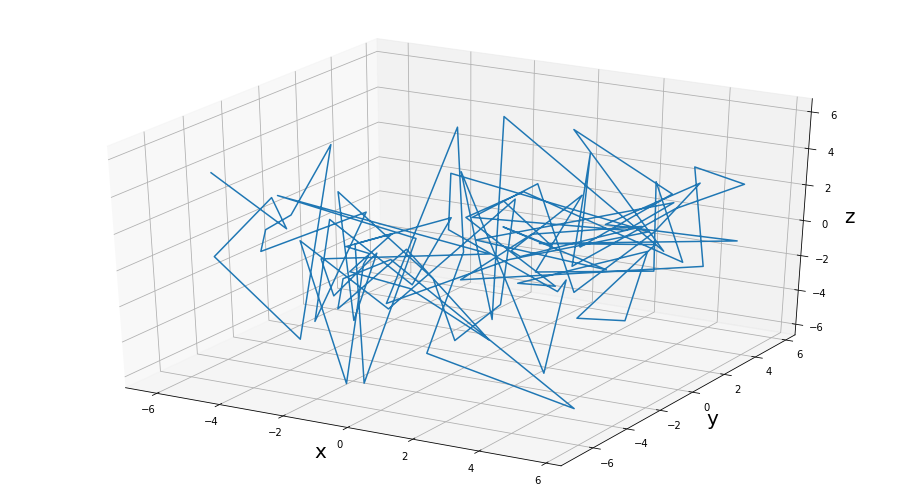

In [151]:
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

LSTM:



In [131]:
N = 1000
X = generate_data(N)

test_size = 0.3

train_test_limit = int((1-test_size)*X.shape[0])

X_train = X[0:train_test_limit,...]
X_test = X[train_test_limit:,...]
X_train.shape

(700, 300)

In [0]:
class gan_LSTM(object): 
    def __init__(self):
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()
    
    def create_generator(self):
        self.generator.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid',input_shape=(1,300)))
        self.generator.add(Dense(units=300,activation ='tanh'))
        self.generator.compile(loss='binary_crossentropy', optimizer='adam')
        
    def create_discriminator(self):
        
        self.discriminator.add(Dense(units=1024,input_dim=300, activation='selu'))

        self.discriminator.add(Dense(units=512,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=256,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=1, activation='sigmoid'))

        self.discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    def create_gan(self):
        
        self.discriminator.trainable=False
        gan_input = Input(shape=(1,300,))
        x = self.generator(gan_input)
        gan_output= self.discriminator(x)
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])

            for _ in tqdm(range(batch_count)):

                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size

                #generate  random noise as an input  to  initialize the  generator
                noise= np.random.normal(0,1, [N,1 ,300])

                generated_trajectory = self.generator.predict(noise)#.reshape(N,100,3)
                #Construct different batches of  real and fake data 

                X= np.concatenate([real_trajectory, generated_trajectory], axis=0)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 1 #0.9bat

                #Pre train discriminator on  fake and real data  before starting the gan. 
                self.discriminator.trainable=True
                
                loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)


                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N,1, 300])
                y_gen = np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss = loss + self.gan.train_on_batch(noise, y_gen)
            loss_list.append(loss)
            loss_list_discriminator.append(loss_discriminator)
        return loss_list, loss_list_discriminator
            #if e == 1 or e % 20 == 0:

                 #plot_generated_images(e, generator)
            
    def generate(self,N):

        noise= np.random.normal(0,1, [N,1, 300])

        return np.transpose(self.generator.predict(noise))

In [133]:
g_LSTM=gan_LSTM()
g_LSTM.generator_summary()
g_LSTM.discriminator_summary()
g_LSTM.gan_summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_99 (Dense)             (None, 300)               30300     
Total params: 190,700
Trainable params: 190,700
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 1024)              308224    
_________________________________________________________________
dense_101 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_102 (Dense)            (None, 256)               131328    
________________________

In [134]:
loss,loss_discriminator = g_LSTM.train(X_train,100,1)

  0%|          | 0/701 [00:00<?, ?it/s]

Epoch 1


 99%|█████████▉| 695/701 [00:15<00:00, 93.17it/s]

ValueError: ignored

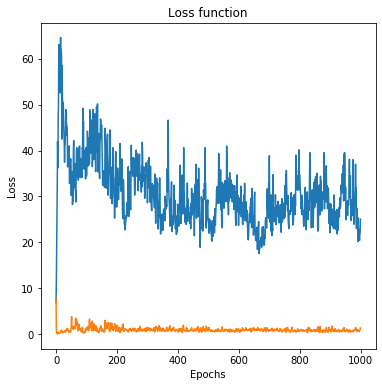

In [0]:
plt.figure(figsize=(6,6))
plt.plot(loss)
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

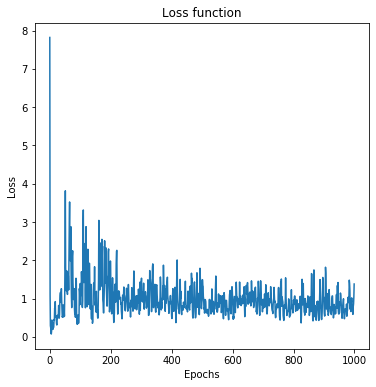

In [0]:
plt.figure(figsize=(6,6))
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

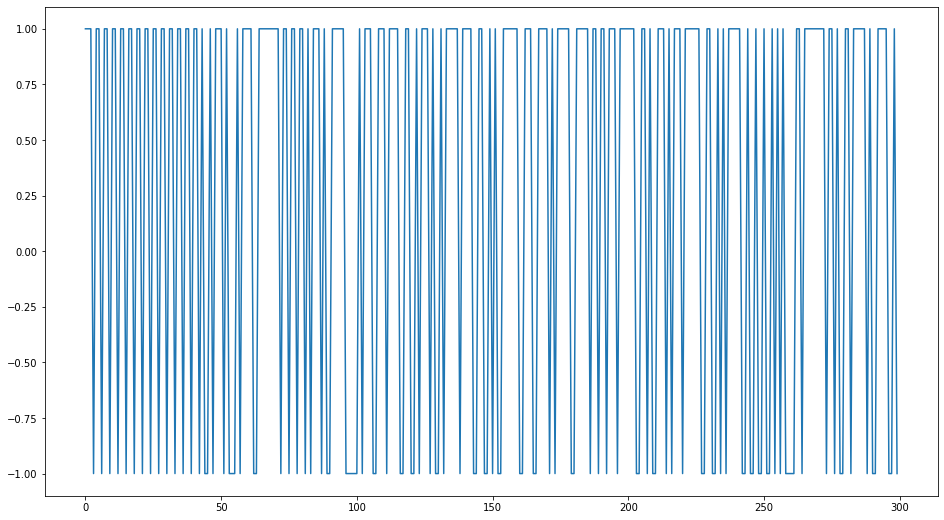

In [0]:
generated_data = g.generate(1)
plt.plot(generated_data)
plt.show()